# **MODELADO PARA PRECIPITACIÓN EN PUEBLA**

Ubicación de la estación: 19.0000, -98.1833




Precipitación v4:  
https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-monthly
https://www.ncei.noaa.gov/data/ghcnm/v4/precipitation/
https://www.ncei.noaa.gov/pub/data/ghcn/v4/products/StationPlots/MX/


Nombres:  
https://www.ncei.noaa.gov/pub/data/ghcn/v4/  
https://www.ncei.noaa.gov/data/ghcnm/v4/precipitation/doc/


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
sns.set(style="whitegrid")

In [56]:
data=pd.read_csv('MXN00021035.csv')

In [57]:
pre=data.iloc[:,6]  # Precipitacion, es la columna 5
date=data.iloc[:,5] # Date, es la columna 6
date = date.astype(str).str.replace(r'(\d{4})(\d{2})', r'\1/\2', regex=True)    # La fecha está como 195210 y la pasamos a 1952/10 
date = pd.to_datetime(date, format='%Y/%m')                                     # Lo convertimos en fecha
pre = pd.Series(pre.values, index=date)                                         # Creamos una Serie
pre

195209
1952-10-01     174
1952-11-01     592
1952-12-01       0
1953-04-01      47
1953-05-01     137
              ... 
2009-08-01    1474
2009-09-01    3161
2009-10-01    1190
2009-11-01     155
2009-12-01      51
Length: 672, dtype: int64

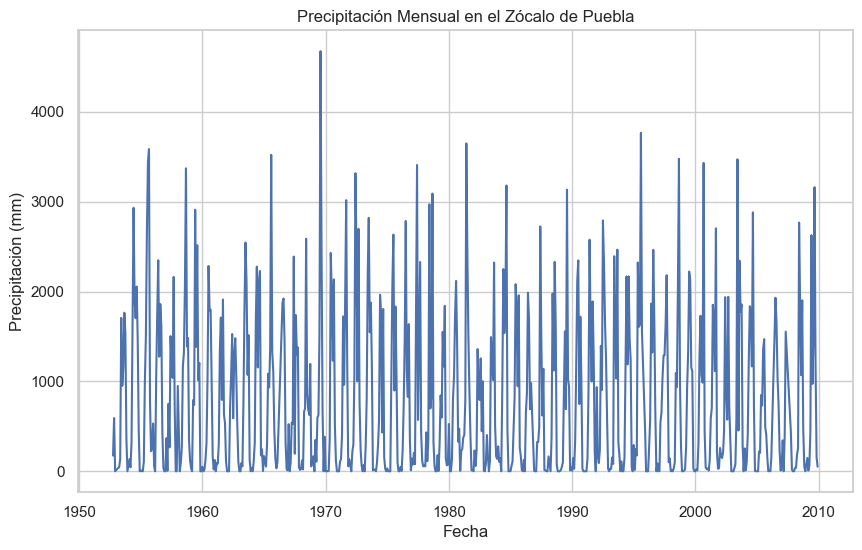

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(pre)
plt.xlabel("Fecha")
plt.ylabel("Precipitación (mm)")
plt.title("Precipitación Mensual en el Zócalo de Puebla")
plt.grid(True)
plt.savefig('imagenes/01-precipitacion.svg', bbox_inches='tight')
plt.show()

# **TRANSFORMACIÓN**

Definición **matemática** de la **transformación Yeo-Johnson**, como se encuentra en la literatura estadística (propuesta por Ingram Olkin y I. Paul Yeo & R. J. Johnson en 2000).

Sea $x \in \mathbb{R}$ un valor (puede ser negativo, cero o positivo). La transformación $T(x; \lambda)$ se define como:

$$
T(x; \lambda) =
\begin{cases}
\frac{[(x + 1)^\lambda - 1]}{\lambda} & \text{si } x \geq 0, \, \lambda \ne 0 \\
\log(x + 1) & \text{si } x \geq 0, \, \lambda = 0 \\
-\frac{[(-x + 1)^{2 - \lambda} - 1]}{2 - \lambda} & \text{si } x < 0, \, \lambda \ne 2 \\
-\log(-x + 1) & \text{si } x < 0, \, \lambda = 2
\end{cases}
$$

La **corrección de sesgo** en la transformación Yeo-Johnson es un detalle técnico importante cuando se usa con la opción `standardize=True` en `scikit-learn` y otras implementaciones.

Cuando transformás datos para que se parezcan a una distribución normal, podés terminar con una media y varianza que no están exactamente en 0 y 1. La **corrección de sesgo** es una **estandarización posterior** que asegura que los datos transformados tengan:

- media 0
- desviación estándar 1

Esto **no forma parte de la transformación Yeo-Johnson en sí**, sino que es un **post-procesamiento** adicional. Pero es importante cuando vas a usar modelos sensibles a escalas.

Supongamos que $T(x_i; \lambda)$ es el valor transformado de $x_i$. Entonces, la corrección de sesgo se hace con una estandarización clásica:

$$
z_i = \frac{T(x_i; \lambda) - \mu_T}{\sigma_T}
$$

donde:

- $\mu_T = \frac{1}{n} \sum_{i=1}^{n} T(x_i; \lambda)$ es la **media** de los datos transformados
- $\sigma_T = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (T(x_i; \lambda) - \mu_T)^2}$ es la **desviación estándar**

In [59]:
from sklearn.preprocessing import PowerTransformer
import numpy as np

In [60]:
pt = PowerTransformer(method='yeo-johnson', standardize=True)   # Crear y ajustar el transformador Yeo-Johnson
ypre = pt.fit_transform(pre.values.reshape(-1, 1))

In [61]:
print("Lambda estimado:", pt.lambdas_)  # Obtener el valor lambda estimado

Lambda estimado: [0.23801569]


Estimación de λ: 0.2380
IC 95% para λ: (0.2068, 0.2702)


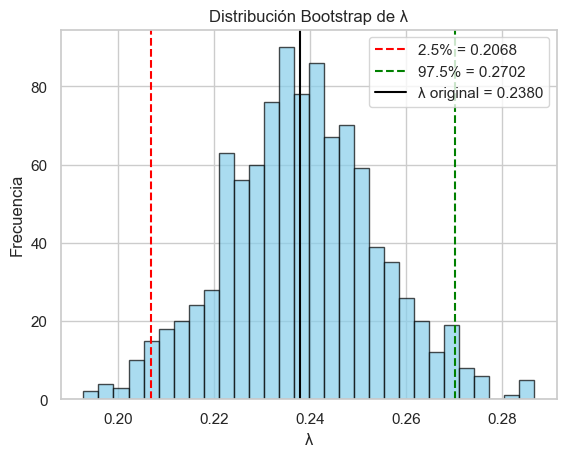

In [62]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

# Supongo que ya tienes tu variable 'pre' como una Serie de pandas o array 1D
X = pre.values.reshape(-1, 1)

# Ajuste original para obtener lambda estimado
pt = PowerTransformer(method='yeo-johnson', standardize=True)
ypre = pt.fit_transform(X)
lambda_est = pt.lambdas_[0]

# Bootstrap para el IC de lambda
n_boot = 1000
lambdas_boot = []

for _ in range(n_boot):
    sample = np.random.choice(X.flatten(), size=len(X), replace=True).reshape(-1, 1)
    pt_boot = PowerTransformer(method='yeo-johnson', standardize=True)
    pt_boot.fit(sample)
    lambdas_boot.append(pt_boot.lambdas_[0])

# Calcular percentiles para el intervalo de confianza al 95%
ci_lower = np.percentile(lambdas_boot, 2.5)
ci_upper = np.percentile(lambdas_boot, 97.5)

print(f"Estimación de λ: {lambda_est:.4f}")
print(f"IC 95% para λ: ({ci_lower:.4f}, {ci_upper:.4f})")

# Gráfico opcional del histograma de los λ bootstrap
plt.hist(lambdas_boot, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(ci_lower, color='red', linestyle='--', label=f'2.5% = {ci_lower:.4f}')
plt.axvline(ci_upper, color='green', linestyle='--', label=f'97.5% = {ci_upper:.4f}')
plt.axvline(lambda_est, color='black', linestyle='-', label=f'λ original = {lambda_est:.4f}')
plt.title('Distribución Bootstrap de λ')
plt.xlabel('λ')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


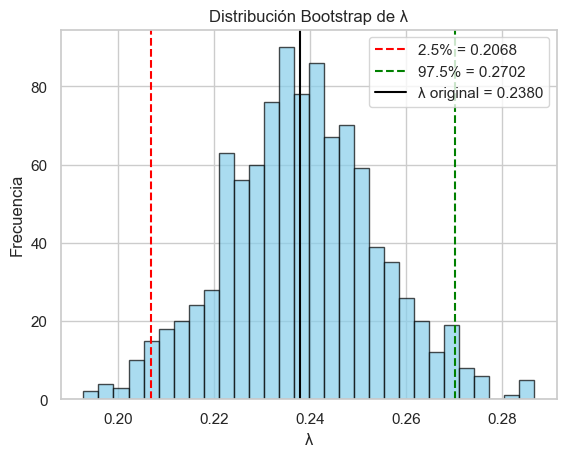

In [63]:
# Gráfico opcional del histograma de los λ bootstrap
plt.hist(lambdas_boot, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(ci_lower, color='red', linestyle='--', label=f'2.5% = {ci_lower:.4f}')
plt.axvline(ci_upper, color='green', linestyle='--', label=f'97.5% = {ci_upper:.4f}')
plt.axvline(lambda_est, color='black', linestyle='-', label=f'λ original = {lambda_est:.4f}')
plt.title('Distribución Bootstrap de λ')
plt.xlabel('λ')
plt.ylabel('Frecuencia')
plt.legend()
plt.savefig('imagenes/02-lambda-yj-bootstrapping.svg', bbox_inches='tight')
plt.show()

se usa un lambda de 0.23  
depende de compu

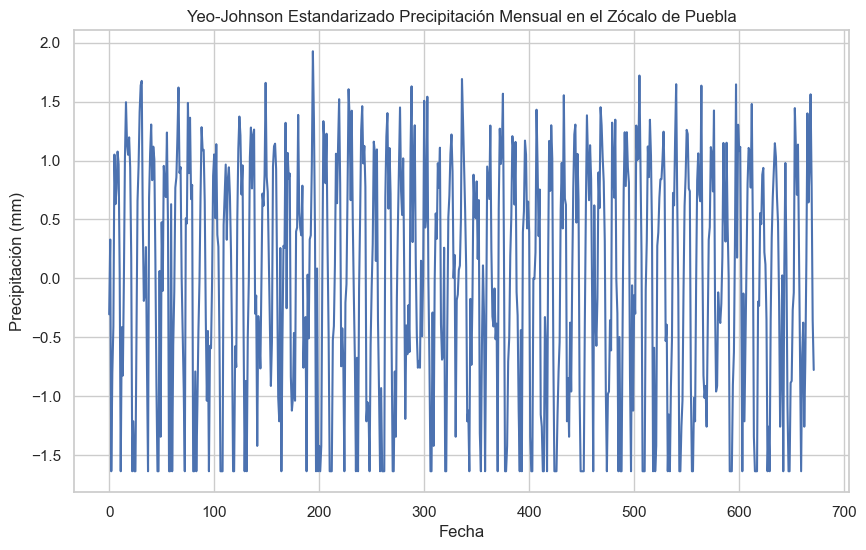

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(ypre)
plt.xlabel("Fecha")
plt.ylabel("Precipitación (mm)")
plt.title("Yeo-Johnson Estandarizado Precipitación Mensual en el Zócalo de Puebla")
plt.grid(True)
plt.savefig('imagenes/03-precipitacion_yeo_johnson.svg', bbox_inches='tight')
plt.show()

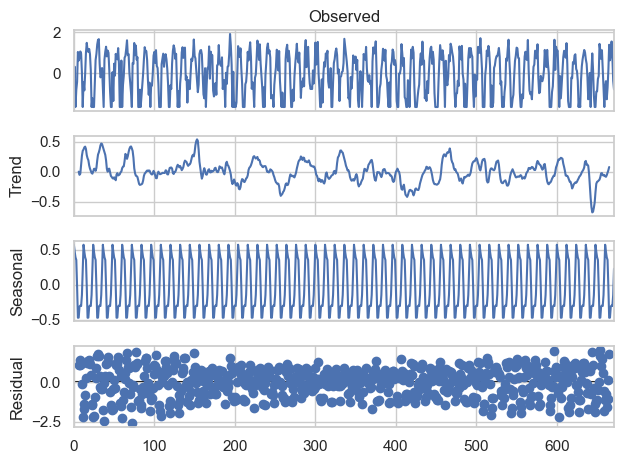

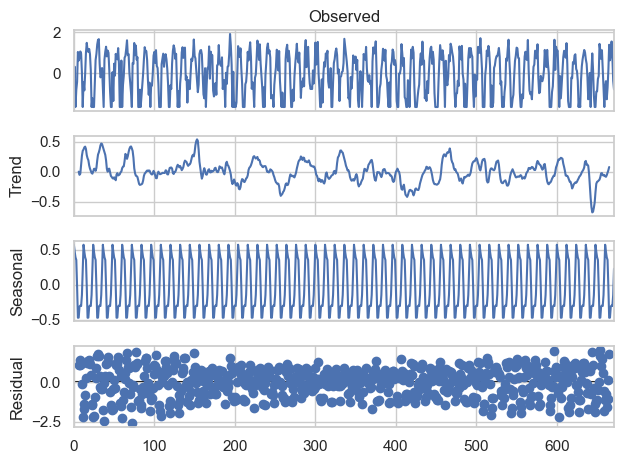

In [65]:
# Identificar estacionalidad
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición estacional
result = seasonal_decompose(ypre, model='additive', period=12)  # Cambia 'period' según la frecuencia de tus datos
result.plot()

# **ESTACIONARIEDAD**

In [66]:
from statsmodels.tsa.stattools import adfuller  

In [67]:
adfuller(ypre)

(-7.092601622125731,
 4.3709379742257517e-10,
 17,
 654,
 {'1%': -3.440388459298194,
  '5%': -2.8659694611921034,
  '10%': -2.569128861019929},
 1158.2583743431305)

In [68]:
estacionariedad = adfuller(ypre)

if estacionariedad[1] < 0.05:
    print("La serie es estacionaria", estacionariedad[1])

La serie es estacionaria 4.3709379742257517e-10


## **AUTOCORRELACIONES**

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
import matplotlib.pyplot as plt
from fac_y_facps_significativas import *    # Este es el archivo que se usa para el curso

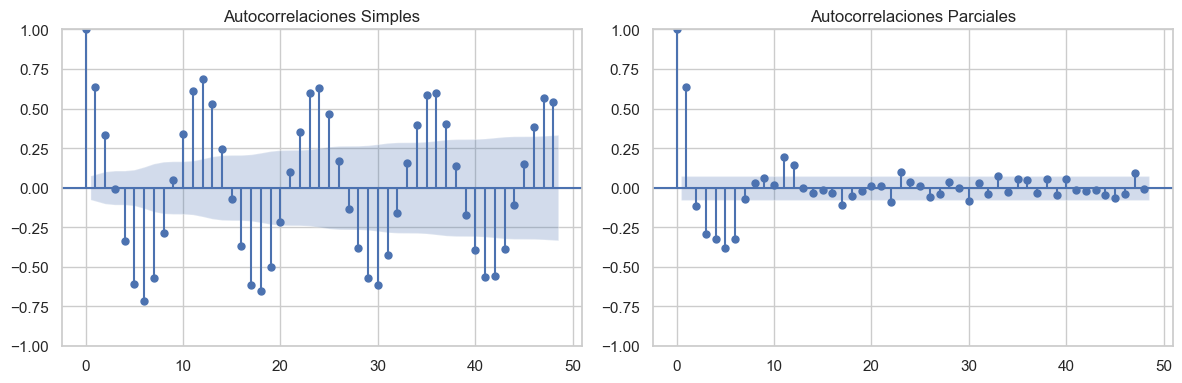

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(ypre, lags=48, ax=axs[0])
# axs[0].set_ylim(-0.04, 0.04)
axs[0].set_title('Autocorrelaciones Simples')

plot_pacf(ypre, lags=48, ax=axs[1])
# axs[1].set_ylim(-0.04, 0.04)
axs[1].set_title('Autocorrelaciones Parciales')

plt.tight_layout()
plt.savefig('imagenes/04-acf_pacf.svg', bbox_inches='tight')
plt.show()


In [71]:
fac = FAC(len(ypre), acf(ypre, nlags=24)[1:] )

Valores de autocorrelacion significativos:
r1: 0.6342847387425632
r2: 0.3322009206680224
r4: -0.33860126674758995
r5: -0.6115854475702546
r6: -0.7190648308075895
r7: -0.5691325786877741
r8: -0.28393632131685287
r10: 0.34122939443275213
r11: 0.6130880086405508
r12: 0.6874989600822966
r13: 0.5275914269967104
r14: 0.2414727291839963
r16: -0.3719149280712861
r17: -0.6128107061643205
r18: -0.6535427016550234
r19: -0.5005469564429801
r22: 0.3535761456770601
r23: 0.5989723862318999
r24: 0.627804531714153


In [72]:
facp = FACP(len(ypre), pacf(ypre, nlags=24)[1:])

Valores de autocorrelacion parcial significativos:
rho 1: 0.6352300215126712
rho 2: -0.11789881064955397
rho 3: -0.29409422369935306
rho 4: -0.3284863556530342
rho 5: -0.3857613954555211
rho 6: -0.3320625526317802
rho 11: 0.20313139379301667
rho 12: 0.15629407166132236
rho 17: -0.12206771400339961
rho 22: -0.08796950273764102
rho 23: 0.10905126340713656


# **MODELADO**

In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Performing stepwise search to minimize aic  
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1311.963, Time=2.54 sec  
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1911.053, Time=0.02 sec  
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1407.341, Time=0.23 sec  
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1529.166, Time=0.31 sec  
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1909.053, Time=0.01 sec  
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1417.826, Time=2.22 sec  
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1349.481, Time=1.62 sec  
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=1301.569, Time=3.69 sec  
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=1322.064, Time=3.47 sec  
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=1314.797, Time=3.97 sec  
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=1308.530, Time=4.63 sec  
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=1334.931, Time=2.91 sec  
 ARIMA(2,0,1)(2,0,1)[12] intercept   : AIC=1318.488, Time=1.83 sec  
 ARIMA(3,0,2)(2,0,1)[12] intercept   : AIC=1339.323, Time=4.08 sec  
 ARIMA(2,0,3)(2,0,1)[12] intercept   : AIC=1221.204, Time=3.77 sec  
 ARIMA(2,0,3)(1,0,1)[12] intercept   : AIC=1214.311, Time=1.58 sec   
 ARIMA(2,0,3)(0,0,1)[12] intercept   : AIC=1207.983, Time=0.95 sec  
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=1211.165, Time=0.35 sec  
 ARIMA(2,0,3)(0,0,2)[12] intercept   : AIC=1209.179, Time=2.47 sec  
 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=1207.567, Time=0.90 sec  
 ARIMA(2,0,3)(2,0,0)[12] intercept   : AIC=1208.378, Time=3.35 sec  
 ARIMA(1,0,3)(1,0,0)[12] intercept   : AIC=1376.094, Time=0.75 sec  
 ARIMA(3,0,3)(1,0,0)[12] intercept   : AIC=1210.214, Time=1.67 sec  
 ARIMA(2,0,4)(1,0,0)[12] intercept   : AIC=1209.398, Time=1.18 sec  
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=1411.187, Time=1.43 sec  
 ARIMA(1,0,4)(1,0,0)[12] intercept   : AIC=1366.547, Time=1.58 sec  
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=1326.643, Time=1.68 sec  
 ARIMA(3,0,4)(1,0,0)[12] intercept   : AIC=1211.408, Time=2.02 sec  
 ARIMA(2,0,3)(1,0,0)[12]             : AIC=1205.567, Time=0.40 sec  
 ARIMA(2,0,3)(0,0,0)[12]             : AIC=1209.165, Time=0.12 sec  
 ARIMA(2,0,3)(2,0,0)[12]             : AIC=1206.378, Time=0.72 sec  
 ARIMA(2,0,3)(1,0,1)[12]             : AIC=1200.512, Time=1.05 sec  
 ARIMA(2,0,3)(0,0,1)[12]             : AIC=1205.983, Time=0.65 sec  
 ARIMA(2,0,3)(2,0,1)[12]             : AIC=1202.486, Time=2.66 sec  
 ARIMA(2,0,3)(1,0,2)[12]             : AIC=1202.484, Time=2.55 sec  
 ARIMA(2,0,3)(0,0,2)[12]             : AIC=1207.179, Time=0.79 sec  
 ARIMA(2,0,3)(2,0,2)[12]             : AIC=1204.463, Time=3.32 sec  
 ARIMA(1,0,3)(1,0,1)[12]             : AIC=1296.044, Time=0.64 sec  
 ARIMA(2,0,2)(1,0,1)[12]             : AIC=1203.823, Time=0.95 sec  
 ARIMA(3,0,3)(1,0,1)[12]             : AIC=1203.281, Time=1.49 sec  
 ARIMA(2,0,4)(1,0,1)[12]             : AIC=1202.477, Time=1.32 sec  
 ARIMA(1,0,2)(1,0,1)[12]             : AIC=inf, Time=0.86 sec  
 ARIMA(1,0,4)(1,0,1)[12]             : AIC=1289.599, Time=0.76 sec  
 ARIMA(3,0,2)(1,0,1)[12]             : AIC=1200.744, Time=1.13 sec  
 ARIMA(3,0,4)(1,0,1)[12]             : AIC=1204.511, Time=1.27 sec  

Best model:  ARIMA(2,0,3)(1,0,1)[12]          
Total fit time: 75.954 seconds

In [74]:
import pmdarima as pm

In [ ]:
# # Encontrar el mejor SARIMA, Basado en ul AIC 
# auto_sarima_model = pm.auto_arima(ypre, 
#                                   seasonal=True, 
#                                   m=12,  # Monthly data, so seasonality is 12
#                                   stepwise=True, 
#                                   suppress_warnings=True, 
#                                   trace=True)

# **Modelo con mejor AIC**

In [76]:
modelo=SARIMAX(ypre,
               order=(2,0,3),
               seasonal_order=(1,0,1,12)).fit()

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  672
Model:             SARIMAX(2, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -592.256
Date:                              Wed, 23 Apr 2025   AIC                           1200.512
Time:                                      22:40:11   BIC                           1236.594
Sample:                                           0   HQIC                          1214.486
                                              - 672                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7104      0.008    203.184      0.000       1.694       1.727
ar.L2         -0.9855      0.009   -115.420      0.000      -1.002      -0.969
ma.L1         -1.4789      0.034    -43.320      0.000      -1.546      -1.412
ma.L2          0.7053      0.058     12.182      0.000       0.592       0.819
ma.L3          0.0654      0.037      1.776      0.076      -0.007       0.138
ar.S.L12       0.8782      0.089      9.880      0.000       0.704       1.052
ma.S.L12      -0.8071      0.108     -7.467      0.000      -1.019      -0.595
sigma2         0.3391      0.017     19.859      0.000       0.306       0.373
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.71
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.23
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
modelo.params

array([ 1.71038349, -0.98548838, -1.47887639,  0.70532359,  0.06542178,
        0.87816382, -0.80707462,  0.3390763 ])

In [110]:
from modulo_raices import *

In [109]:
modulo_raices(p1=-modelo.params[0], p2=-modelo.params[1], p12=-modelo.params[5])

Raíces del polinomio característico: [-1.13999182+0.j         -0.94912496+0.6144677j  -0.94912496-0.6144677j
 -0.4515991 +1.00422439j -0.4515991 -1.00422439j  0.15340793+1.03336171j
  0.15340793-1.03336171j  0.6012712 +0.72419916j  0.6012712 -0.72419916j
  0.90328982+0.j          0.76439592+0.39186861j  0.76439592-0.39186861j]

Módulo de las raíces: [1.13999182 1.13066738 1.13066738 1.10109417 1.10109417 1.04468676
 1.04468676 0.9412712  0.9412712  0.90328982 0.85898902 0.85898902]

¿Las raíces están fuera del circulo unitario?  False


In [ ]:
modulo_raices(p1=modelo.params[2], p2=modelo.params[3], p3=modelo.params[4], p12=modelo.params[6])

Raíces del polinomio característico: [-1.12938855+0.j         -0.94643772+0.60281184j -0.94643772-0.60281184j
 -0.46341069+0.99500751j -0.46341069-0.99500751j  0.13527813+1.03867284j
  0.13527813-1.03867284j  0.59179344+0.74969459j  0.59179344-0.74969459j
  0.91755409+0.j          0.78869407+0.4067659j   0.78869407-0.4067659j ]

Módulo de las raíces: [1.12938855 1.12210805 1.12210805 1.097629   1.097629   1.04744519
 1.04744519 0.95512379 0.95512379 0.91755409 0.88741018 0.88741018]

¿Las raíces están fuera del circulo unitario?  False



$$
\text{SARIMA}(2,0,3) \times (1,0,1)_{12}
$$

con los coeficientes:

- AR(1): $\phi_1 = 1.7104$
- AR(2): $\phi_2 = -0.9855$
- MA(1): $\theta_1 = -1.4789$
- MA(2): $\theta_2 = 0.7053$
- MA(3): $\theta_3 = 0.0654$
- AR(12): $\Phi_1 = 0.8782$
- MA(12): $\Theta_1 = -0.8071$
$$
(1
- 1.7104 \, B 
+ 0.9855 \, B^2 
- 0.8782 \, B^{12})W_t=
(1
- 1.4789 \, B 
+ 0.7053 \, B^2 
+ 0.0654 \, B^3
- 0.8071 \, B^{12})\varepsilon_{t}
$$

$W_t = T(X_t)$ con la transformación de Yeo-Johnson y $\varepsilon_t \sim \mathcal{N}(0, 1)$

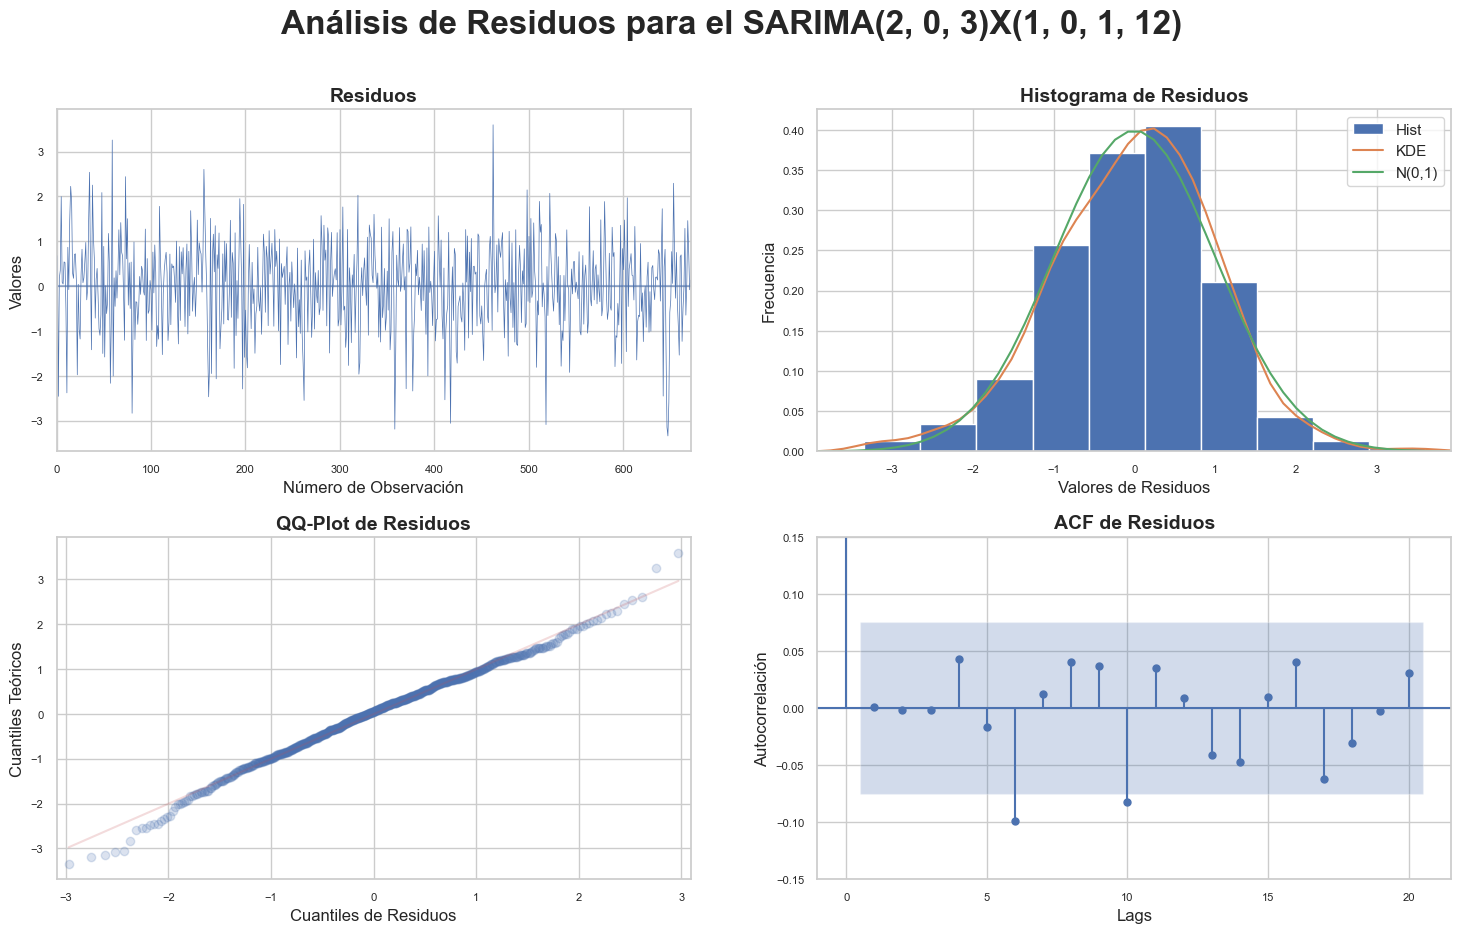

In [77]:
from matplotlib.collections import PathCollection

fig = modelo.plot_diagnostics(figsize=(18, 10), lags=20)

axes = fig.axes
# Cambiar el primer gráfico a la izquierda
axes[0].set_title("Residuos", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Valores")
axes[0].set_xlabel("Número de Observación")
axes[0].tick_params(axis='x', labelsize=8)
axes[0].tick_params(axis='y', labelsize=8)
for line in axes[0].lines:
    line.set_linewidth(0.5)

# Cambiar el segundo gráfico a la derecha
axes[1].set_title("Histograma de Residuos", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Frecuencia")
axes[1].set_xlabel("Valores de Residuos")
axes[1].tick_params(axis='x', labelsize=8)
axes[1].tick_params(axis='y', labelsize=8)

# Cambiar el tercer gráfico de abajo a la izquierda
axes[2].set_title("QQ-Plot de Residuos", fontsize=14, fontweight='bold')
axes[2].set_ylabel("Cuantiles Teóricos")
axes[2].set_xlabel("Cuantiles de Residuos")
axes[2].tick_params(axis='x', labelsize=8)
axes[2].tick_params(axis='y', labelsize=8)
for line in axes[2].lines:
    # line.set_markerfacecolor('green')
    # line.set_markeredgecolor('white')
    line.set_alpha(0.2)

# Cambiar el cuarto gráfico de abajo a la derecha
axes[3].set_title("ACF de Residuos", fontsize=14, fontweight='bold')
axes[3].set_ylabel("Autocorrelación")
axes[3].set_xlabel("Lags")
axes[3].set_ylim(-0.15, 0.15)
axes[3].tick_params(axis='x', labelsize=8)
axes[3].tick_params(axis='y', labelsize=8)

plt.subplots_adjust(hspace=0.25, wspace=0.2)
plt.suptitle("Análisis de Residuos para el SARIMA(2, 0, 3)X(1, 0, 1, 12)", fontsize=24, fontweight='bold')
plt.savefig('imagenes/05-analisis-de-residuos.svg', bbox_inches='tight')
plt.show()


# **FORECAST**

In [78]:
# Pronóstico para 12 meses hacia el futuro
forecast = modelo.forecast(steps=12)

In [79]:
# Obtener pronóstico con intervalos
pred = modelo.get_forecast(steps=12)

In [80]:
# Media pronosticada
forecast_mean = pred.predicted_mean
forecast_mean

array([-0.94461724, -0.90616886, -0.82132534, -0.43711095,  0.20920137,
        0.76886687,  0.92435963,  0.96886022,  0.82134122,  0.2614053 ,
       -0.43572131, -0.88243069])

In [81]:
# Intervalos de confianza
int_conf = pred.conf_int()
int_conf

array([[-2.08590934,  0.19667486],
       [-2.07764587,  0.26530815],
       [-2.00023392,  0.35758323],
       [-1.61670922,  0.74248732],
       [-0.97198666,  1.3903894 ],
       [-0.42113048,  1.95886422],
       [-0.28021401,  2.12893327],
       [-0.24866455,  2.186385  ],
       [-0.40196733,  2.04464976],
       [-0.96223935,  1.48504995],
       [-1.66125622,  0.7898136 ],
       [-2.11647122,  0.35160984]])

In [82]:
# Obtenemos el forecast real
forecast_real = pt.inverse_transform(forecast_mean.reshape(-1, 1))

In [83]:
# Los intervalos de confianza reales
lower_bound_real = pt.inverse_transform(int_conf[:, 0].reshape(-1, 1))
upper_bound_real = pt.inverse_transform(int_conf[:, 1].reshape(-1, 1))

In [84]:
# Generate forecast dates and plot forecast series
forecast_index = pd.date_range(start=pre.index[-2], periods=13, freq='ME')[1:]

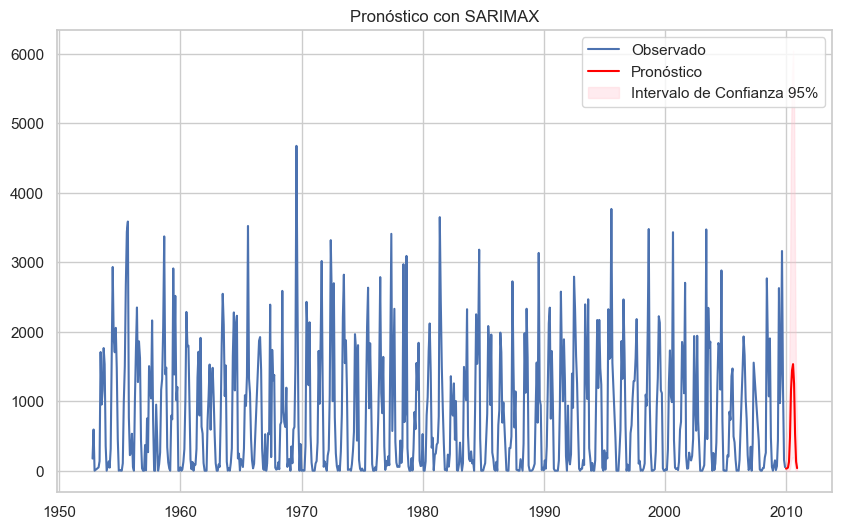

In [85]:
plt.figure(figsize=(10, 6))

# Serie original
plt.plot(pre, label='Observado')

# Pronóstico
plt.plot(forecast_index, forecast_real, label='Pronóstico', color='red')    # Pronóstico en rojo

# Intervalos
plt.fill_between(forecast_index, 
                 lower_bound_real.flatten(),
                 upper_bound_real.flatten(),
                 color='pink', alpha=0.3, label='Intervalo de Confianza 95%')

plt.legend()
plt.title('Pronóstico con SARIMAX') 
plt.savefig('imagenes/06-pronostico-sarimax.svg', bbox_inches='tight')
plt.show()

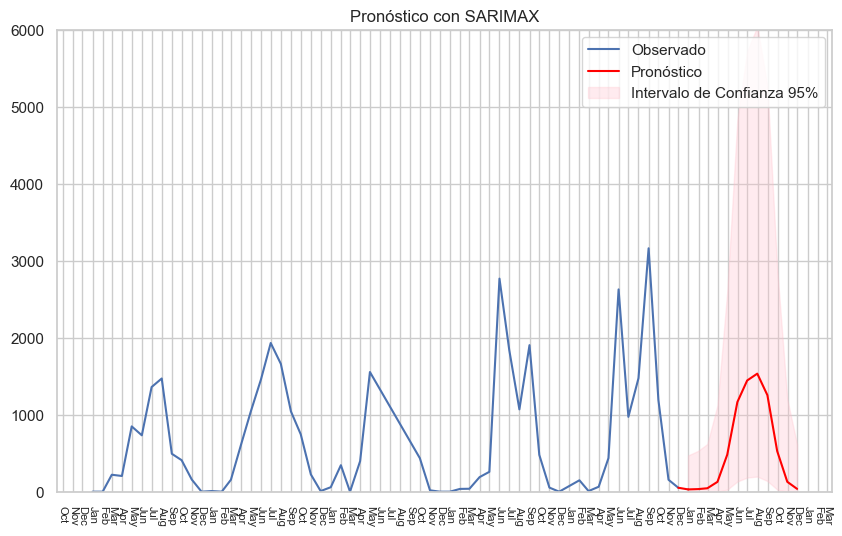

In [86]:
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())           # set ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))    # format ticks to show abbreviated month

# Filter the observed series from 2005 onward
obs = pre[pre.index >= '2005-01-01']

# Plot the observed series
plt.plot(obs, label='Observado')
plt.plot(forecast_index, forecast_real, label='Pronóstico', color='red')

# Add a red line connecting the last observed point with the first forecast point
last_obs_date = obs.index[-1]
last_obs_value = obs.iloc[-1]
first_fc_date = forecast_index[0]
first_fc_value = forecast_real[0, 0]
plt.plot([last_obs_date, first_fc_date], [last_obs_value, first_fc_value], color='red', linewidth=1.5)

# Intervalos
plt.fill_between(forecast_index, 
                 lower_bound_real.flatten(),
                 upper_bound_real.flatten(),
                 color='pink', alpha=0.3, label='Intervalo de Confianza 95%')

plt.xticks(rotation=270, size=8)
plt.legend()
plt.title('Pronóstico con SARIMAX')
plt.ylim(0, 6000)
plt.grid(True)
plt.savefig('imagenes/07-pronostico-sarimax-zoom.svg', bbox_inches='tight')
plt.show()

# **PRONÓSTICO ÓPTIMO**

In [87]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  672
Model:             SARIMAX(2, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -592.256
Date:                              Wed, 23 Apr 2025   AIC                           1200.512
Time:                                      22:40:14   BIC                           1236.594
Sample:                                           0   HQIC                          1214.486
                                              - 672                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7104      0.008    203.184      0.000       1.694       1.727
ar.L2         -0.9855      0.009   -115.420      0.000      -1.002      -0.969
ma.L1         -1.4789      0.034    -43.320      0.000      -1.546      -1.412
ma.L2          0.7053      0.058     12.182      0.000       0.592       0.819
ma.L3          0.0654      0.037      1.776      0.076      -0.007       0.138
ar.S.L12       0.8782      0.089      9.880      0.000       0.704       1.052
ma.S.L12      -0.8071      0.108     -7.467      0.000      -1.019      -0.595
sigma2         0.3391      0.017     19.859      0.000       0.306       0.373
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.71
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.23
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

$$
(1
- 1.7104 \, B 
+ 0.9855 \, B^2 
- 0.8782 \, B^{12})W_t=
(1
- 1.4789 \, B 
+ 0.7053 \, B^2 
+ 0.0654 \, B^3
- 0.8071 \, B^{12})\varepsilon_{t}
$$

$W_t = T(X_t)$ con la transformación de Yeo-Johnson y $\varepsilon_t \sim \mathcal{N}(0, 1)$

$$
W_t = 
1.7104 \, W_{t-1} 
- 0.9855 \, W_{t-2} 
+ 0.8782 \, W_{t-12}
+ \varepsilon_t 
- 1.4789 \, \varepsilon_{t-1} 
+ 0.7053 \, \varepsilon_{t-2} 
+ 0.0654 \, \varepsilon_{t-3} 
- 0.8071 \, \varepsilon_{t-12}
$$

$$
W_t(h) = 
1.71 \, \underset{t}{\mathbb{E}}[W_{t+h-1}] 
- 0.99 \, \underset{t}{\mathbb{E}}[W_{t+h-2}] 
+ 0.88 \, \underset{t}{\mathbb{E}}[W_{t+h-12}]
+ \underset{t}{\mathbb{E}}[\varepsilon_{t+h}] 
- 1.48 \, \underset{t}{\mathbb{E}}[\varepsilon_{t+h-1}] 
+ 0.71 \, \underset{t}{\mathbb{E}}[\varepsilon_{t+h-2}] 
+ 0.07 \, \underset{t}{\mathbb{E}}[\varepsilon_{t+h-3}] 
- 0.81 \, \underset{t}{\mathbb{E}}[\varepsilon_{t+h-12}]
$$

In [89]:
res = modelo.resid

In [91]:
pd.DataFrame(res).to_csv('residuos.csv', index=False)
pd.DataFrame(ypre).to_csv('ypre.csv', index=False)

In [44]:
from pronostico_optimo import *

In [45]:
pronosticos, lower, upper = po(H=12, modelo=modelo, ypre=ypre, res=res, t0=671)

In [46]:
# inversa de Yeo-Jhonson
pronostico_real_eco = pt.inverse_transform(pronosticos)
lower_real_eco = pt.inverse_transform(lower)
upper_real_eco = pt.inverse_transform(upper)

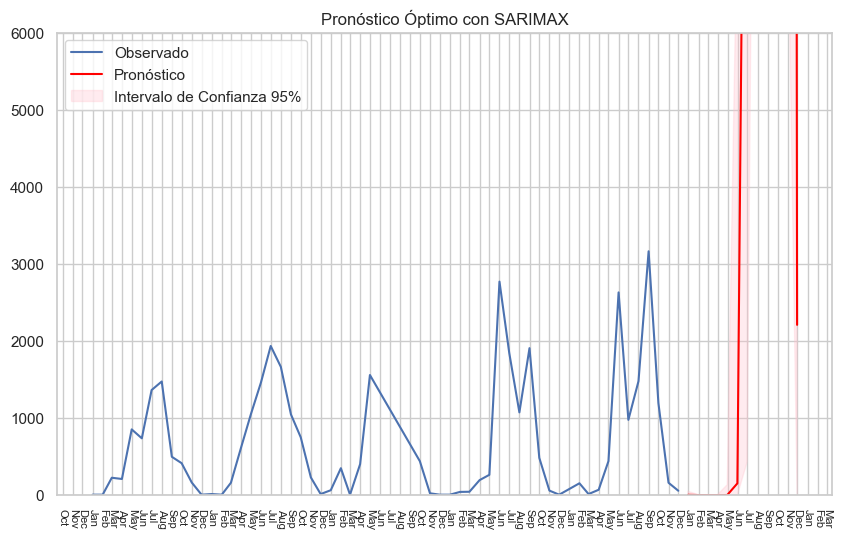

In [47]:
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # set ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # format ticks to show abbreviated month

# Filter the observed series from 2005 onward
obs = pre[pre.index >= '2005-01-01']

# Plot the observed series
plt.plot(obs, label='Observado')
plt.plot(forecast_index, pronostico_real_eco, label='Pronóstico', color='red')


# Intervalos
plt.fill_between(forecast_index, 
                 lower_real_eco.flatten(),
                 upper_real_eco.flatten(),
                 color='pink', alpha=0.3, label='Intervalo de Confianza 95%')

plt.xticks(rotation=270, size=8)
plt.legend()
plt.title('Pronóstico Óptimo con SARIMAX')
plt.ylim(0, 6000)
plt.grid(True)
plt.savefig('imagenes/08-pronostico-optimo-sarimax.svg', bbox_inches='tight')
plt.show()